In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from utils import inverse_logit_transform, prepare_transformed_dataset, SORTER_NAMES

In [2]:
train_data, test_data = prepare_transformed_dataset()
# train_data.drop(columns=['sorter_id'], inplace=True)
# test_data.drop(columns=['sorter_id'], inplace=True)

Loaded from cache


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [3]:
X_train = train_data.drop(columns=['sorter_id', 'agreement_score'])
y_train = train_data['agreement_score']
X_test = test_data.drop(columns=['sorter_id','agreement_score'])
y_test = test_data['agreement_score']

In [4]:
# Model with parameters unchanged

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [5]:
y_preds = model.predict(X_test)

In [6]:
rescaled_y_preds = inverse_logit_transform(y_preds)
rescaled_y_test = inverse_logit_transform(y_test)

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted logit agreement score')

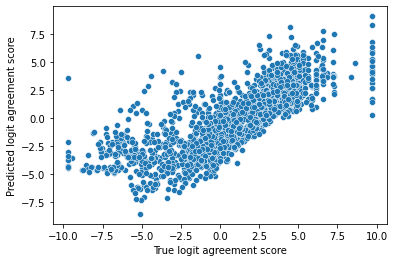

In [7]:
sns.scatterplot(y_test, y_preds)
plt.xlabel('True logit agreement score')
plt.ylabel('Predicted logit agreement score')

<AxesSubplot:ylabel='Count'>

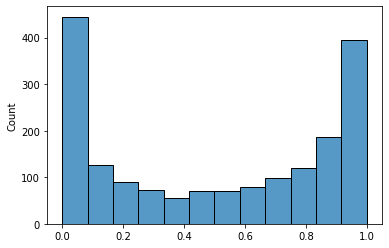

In [8]:
sns.histplot(rescaled_y_preds)

<AxesSubplot:xlabel='agreement_score', ylabel='Count'>

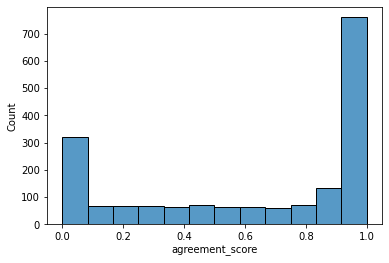

In [9]:
sns.histplot(rescaled_y_test)

In [13]:
fp_preds = rescaled_y_preds >= 0.5
fp_test = rescaled_y_test >= 0.5

general_f1_score = f1_score(fp_preds, fp_test)

In [14]:
rmse = np.sqrt(mean_squared_error(rescaled_y_preds, rescaled_y_test))
print(f'RMSE for general model ran on test set w/ all sorters: {rmse}')
print(f'F1 Score for model when predicting whether or not agreement score >= 0.5: {general_f1_score}')

RMSE for general model ran on test set w/ all sorters: 0.27402956039055154
F1 Score for model when predicting whether or not agreement score >= 0.5: 0.8361904761904762


In [16]:
sorter_rmse = []
sorter_fp_f1_scores = []
for sorter in SORTER_NAMES:

    sorter_idx_train = train_data[train_data['sorter_id'] == SORTER_NAMES.index(sorter)].index
    sorter_idx_test = test_data[test_data['sorter_id'] == SORTER_NAMES.index(sorter)].index
    X_train = train_data.iloc[sorter_idx_train].drop(columns=['sorter_id', 'agreement_score'])
    y_train = train_data.iloc[sorter_idx_train]['agreement_score']
    X_test = test_data.iloc[sorter_idx_test].drop(columns=['sorter_id','agreement_score'])
    y_test = test_data.iloc[sorter_idx_test]['agreement_score']

    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)

    rescaled_y_preds = inverse_logit_transform(y_preds)
    rescaled_y_test = inverse_logit_transform(y_test)

    sorter_rmse.append(np.sqrt(mean_squared_error(rescaled_y_preds, rescaled_y_test)))

    fp_preds = rescaled_y_preds >= 0.5
    fp_test = rescaled_y_test >= 0.5

    sorter_fp_f1_scores.append(f1_score(fp_preds, fp_test))

    print(len(fp_test))

287
315
166
580
248
213


In [21]:
print(f'RMSEs for linear regressor ran and tested on individual sorter data: {dict(zip(SORTER_NAMES, sorter_rmse))}')
print(f'F1 Score for specific sorter models when predicting whether or not agreement score >= 0.5: {dict(zip(SORTER_NAMES, sorter_fp_f1_scores))}')

RMSEs for linear regressor ran and tested on individual sorter data: {'ironclust': 0.24946829733845532, 'jrclust': 0.22023384403310192, 'kilosort2': 0.2367458018536755, 'mountainsort4': 0.2814280313895435, 'spykingcircus': 0.2022917212218765, 'tridesclous': 0.2258430515199291}
F1 Score for specific sorter models when predicting whether or not agreement score >= 0.5: {'ironclust': 0.8936170212765958, 'jrclust': 0.752851711026616, 'kilosort2': 0.9156626506024096, 'mountainsort4': 0.7578947368421052, 'spykingcircus': 0.9219143576826196, 'tridesclous': 0.888268156424581}
